<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Shap" data-toc-modified-id="Shap-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Shap</a></span><ul class="toc-item"><li><span><a href="#Shap-Plots-for-Tree-Models" data-toc-modified-id="Shap-Plots-for-Tree-Models-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Shap Plots for Tree Models</a></span></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
# %matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format='retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import xgboost as xgb
import shap

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,sklearn,matplotlib,lightgbm,xgboost,shap

Ethen 2020-09-04 15:19:35 

CPython 3.6.4
IPython 7.15.0

numpy 1.19.1
pandas 1.0.5
sklearn 0.23.1
matplotlib 3.1.0
lightgbm 3.0.0
xgboost 1.0.0
shap 0.29.3


# Shap

Some standard way of evaluating models:

- model-performance on the train/validation/test set.
- Calibration curve if probability estimate is needed.
- Feature importance plot to inspect feature contribution.
- Manually inspect top and worst performing examples to identify gaps.

We'll reproduce the example provided by the [shap package](https://nbviewer.jupyter.org/github/slundberg/shap/blob/master/notebooks/tree_explainer/Census%20income%20classification%20with%20XGBoost.ipynb).

In [2]:
X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)
print('dimension:', X_display.shape)
X_display.head()

dimension: (32561, 12)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


In [4]:
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

In [19]:
X_test

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
18329,39.0,4,10.0,0,4,1,4,0,0.0,625.0,40.0,39
997,48.0,1,13.0,0,4,1,4,1,0.0,0.0,58.0,39
13225,22.0,4,10.0,2,8,4,4,1,0.0,0.0,35.0,39
6837,23.0,7,8.0,4,4,0,4,1,0.0,0.0,40.0,39
29132,50.0,6,13.0,2,12,4,4,1,0.0,0.0,8.0,39
...,...,...,...,...,...,...,...,...,...,...,...,...
23959,19.0,4,10.0,4,1,3,4,0,0.0,0.0,20.0,39
30638,25.0,5,9.0,2,12,4,4,1,0.0,0.0,60.0,0
6640,18.0,0,10.0,4,0,3,4,0,0.0,0.0,6.0,39
19186,23.0,4,4.0,4,7,3,2,0,0.0,0.0,40.0,6


In [11]:
params = {
    "learning_rate": 0.01,
    "objective": "binary:logistic",
    # "boost_from_average": True
}
num_boost_round = 50

model = xgb.train(params, d_train, num_boost_round)
model.predict(d_test)

array([0.3116163 , 0.42201936, 0.3622437 , ..., 0.3058756 , 0.3058756 ,
       0.47008213], dtype=float32)

In [14]:
model.save_model('test.xgb')

In [15]:
!pwd

/Users/mingyuliu/programming/shap


In [12]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap_values

array([[ 6.2823191e-02, -6.0884206e-04,  2.1186846e-01, ...,
        -1.3227075e-02, -4.4713680e-02,  0.0000000e+00],
       [ 3.0171400e-02, -1.3248499e-03,  1.9561446e-01, ...,
        -5.0024509e-02, -2.5635570e-01,  0.0000000e+00],
       [ 3.0065473e-02,  9.2175280e-05, -7.6408297e-02, ...,
        -9.0757702e-03, -1.5831212e-02,  0.0000000e+00],
       ...,
       [ 2.8605355e-02,  9.2175280e-05, -7.4139088e-02, ...,
        -9.1189798e-03, -1.4594255e-02,  0.0000000e+00],
       [-6.1726309e-02,  5.7193989e-05, -4.4587191e-02, ...,
        -8.8865701e-03, -3.5211399e-02,  0.0000000e+00],
       [ 3.0286169e-02,  6.3820742e-04, -6.6239774e-02, ...,
        -8.6668748e-03, -1.6814781e-03,  0.0000000e+00]], dtype=float32)

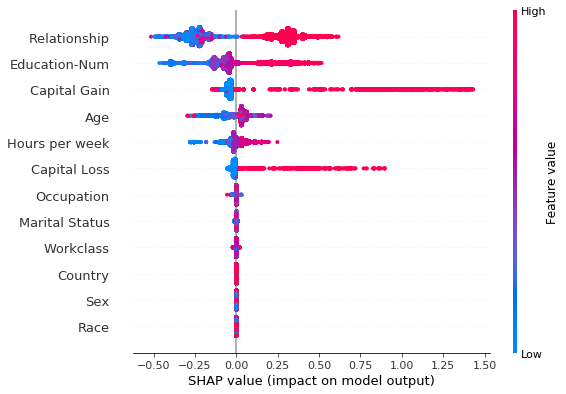

In [13]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 10, 8
plt.rcParams['font.size'] = 12

shap.summary_plot(shap_values, X, show=False, plot_type='dot')
# plt.savefig('../shap.png', dpi=300, bbox_inches='tight')

In [3]:
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

In [11]:
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100
    # "boost_from_average": True
}
num_boost_round = 10000
early_stopping_rounds = 50
verbose_eval = 100

model = lgb.train(params, d_train, num_boost_round,
                  valid_sets=[d_test],
                  early_stopping_rounds=early_stopping_rounds,
                  verbose_eval=verbose_eval)

NameError: name 'xgb' is not defined

## Shap Plots for Tree Models

In [5]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap_values

array([[ 4.90548484e-01, -2.75392657e-01,  5.84700009e-01, ...,
        -2.49908066e-02, -1.24473086e-01,  1.64659509e-02],
       [ 1.00895059e+00, -3.29944730e-01,  7.85310857e-01, ...,
        -7.53558627e-02, -1.13838141e+00,  1.50493404e-02],
       [ 4.37856520e-01,  1.98391007e-02, -3.08878503e-01, ...,
        -2.06305188e-02, -2.67436729e-02,  3.85132536e-03],
       ...,
       [ 8.13230626e-01, -2.03190278e-02, -3.91046300e-01, ...,
        -3.04790494e-02, -1.54367909e-02,  1.16830782e-02],
       [-1.89759917e+00, -2.31645411e-02, -2.65437686e-01, ...,
        -3.25766309e-02, -1.22408956e+00, -3.59659083e-04],
       [ 1.03679176e+00,  2.16312813e-01, -4.57916496e-01, ...,
        -2.36833985e-02,  1.14525043e-01,  1.11461339e-02]])

https://problemsolvingwithpython.com/06-Plotting-with-Matplotlib/06.04-Saving-Plots/

To get an overview of which features contributes most to a model we can plot every features' SHAP values for every sample of our dataset. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the impacts each feature has on the model output. The color represents the feature value (red high, blue low).

An interesting observation from the plot is, in general relationship has a larger impact on the model than the capital gain feature, but for those samples where capital gain matters, it has a much larger impact. In other words, capital gain effects a few predictions by a large amount, while relationship effects all predictions by a smaller amount.

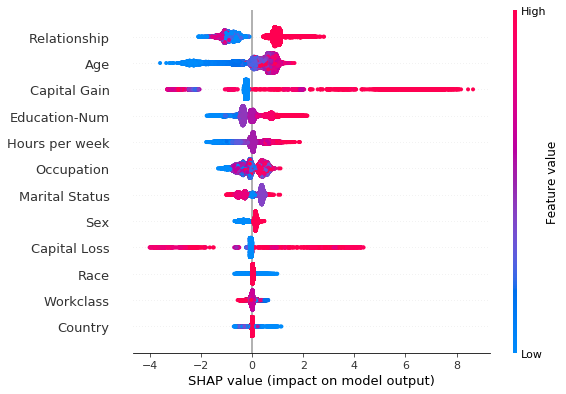

In [6]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 10, 8
plt.rcParams['font.size'] = 12

shap.summary_plot(shap_values, X, show=False, plot_type='dot')
# plt.savefig('../shap.png', dpi=300, bbox_inches='tight')

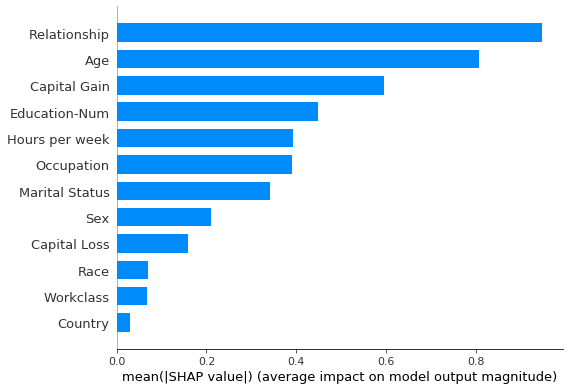

In [7]:
shap.summary_plot(shap_values, X, show=False, plot_type="bar")
# plt.savefig('../shap.png', dpi=300, bbox_inches='tight')

In [8]:
def get_feature_importance(model, threshold=0.001, ascending=True):
    importance = model.feature_importance(importance_type='gain')
    feature_imp_dict = {
        feature: imp
        for feature, imp in zip(model.feature_name(), importance)
    }
    df_feature_imp = pd.DataFrame.from_dict(feature_imp_dict, orient='index').reset_index()
    df_feature_imp.columns = ['feature', 'importance']
    df_feature_imp['importance'] = (df_feature_imp['importance'] /
                                    df_feature_imp['importance'].sum())
    df_feature_imp = df_feature_imp[df_feature_imp['importance'] >= threshold]
    df_feature_imp = (df_feature_imp
                      .sort_values('importance', ascending=ascending)
                      .reset_index(drop=True))
    return df_feature_imp

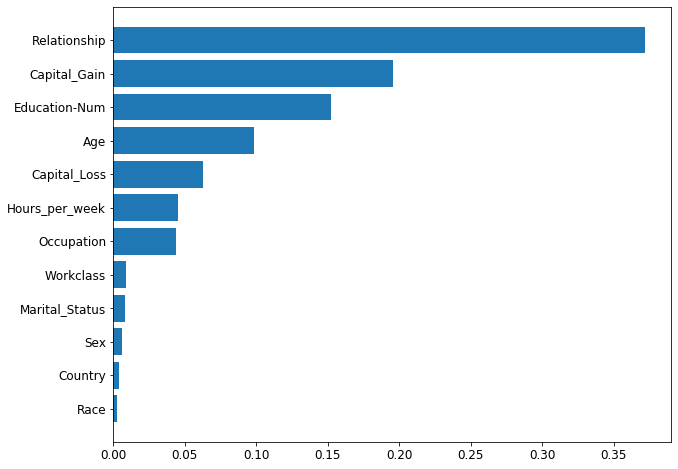

In [9]:
df_feature_imp = get_feature_importance(model)
plt.barh(df_feature_imp['feature'], df_feature_imp['importance'])
plt.show()

In [12]:
import os
from typing import Optional, List


def compute_shap_summary_plots(model, X, show: bool=False, save_dir: Optional[str]='.') -> List[str]:
    """
    Computes the shap values and stores the summary plots, both the dot, ``shap_summary_dot.png``,
    and bar, ``shap_summary_bar.png``, plot will be stored and the exact path will be returned.

    Parameters
    ----------
    model :
        Trained model.
    
    X :
        Data that we'll use to compute the shap values.

    show : bool, default False
        Whether to show the plots on the console or jupyter notebook.

    save_dir : str, default '.'
        Directory where we'll store the plots. None means it will not save the plot and only show
        the plots on the console or jupyter notebook.

    Returns
    -------
    plot_paths : list[str]
        Path that stores the shap dot and bar summary plot.
    """
    import shap
    import matplotlib.pyplot as plt

    if save_dir is not None:
        # create the directory if it doesn't exist already
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir, exist_ok=True)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    plot_paths = []
    for plot_type in ('dot', 'bar'):
        shap.summary_plot(shap_values, X, plot_type=plot_type, show=False)

        # we need to get a hold on the figure instance if we wish to save the figure after displaying it
        # https://stackoverflow.com/questions/21875356/saving-a-figure-after-invoking-pyplot-show-results-in-an-empty-file
        fig = plt.gcf()
        if show:
            plt.show()

        if save_dir is not None:
            # specify dpi for high resolution plot, and bbox_inches to prevent
            # chopping off the plot's margin
            plot_path = os.path.join(save_dir, 'shap_summary_{}.png'.format(plot_type))
            fig.savefig(plot_path, dpi=300, bbox_inches='tight')
            plot_paths.append(plot_path)

        plt.close()

    return plot_paths

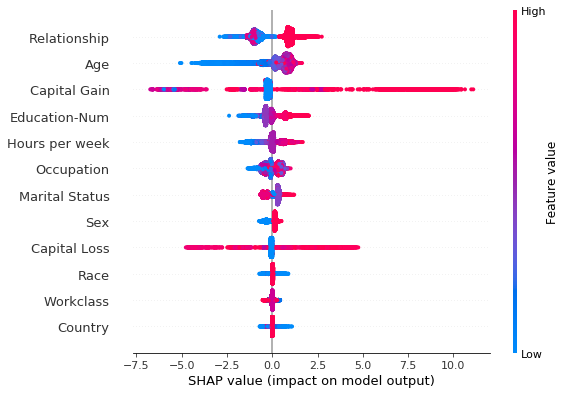

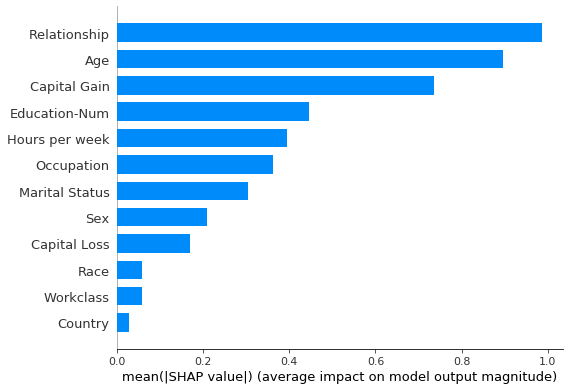

[]

In [14]:
compute_shap_summary_plots(model, X, show=True, save_dir=None)

# Reference

- [Jupyter Notebook: Census income classification with XGBoost](https://nbviewer.jupyter.org/github/slundberg/shap/blob/master/notebooks/tree_explainer/Census%20income%20classification%20with%20XGBoost.ipynb)